In [1]:
import collections
import pandas as pd
import numpy as np

import pylab
import calendar
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv("training.csv", parse_dates=["PurchDate"])
print("shape of data:",data.shape)
data.head(3).transpose()

shape of data: (72983, 34)


,0,1,2
RefId,1,2,3
IsBadBuy,0,0,0
PurchDate,2009-12-07 00:00:00,2009-12-07 00:00:00,2009-12-07 00:00:00
Auction,ADESA,ADESA,ADESA
VehYear,2006,2004,2005
VehicleAge,3,5,4
Make,MAZDA,DODGE,DODGE
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6
Trim,i,ST,SXT
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV


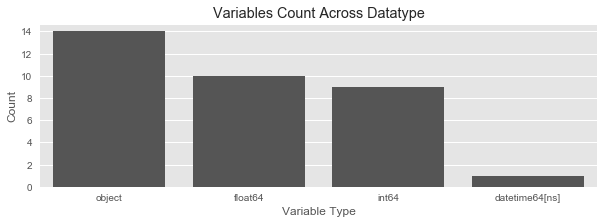

In [3]:
dataTypeDf = pd.DataFrame(data.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(10,3)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax,color="#555555")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

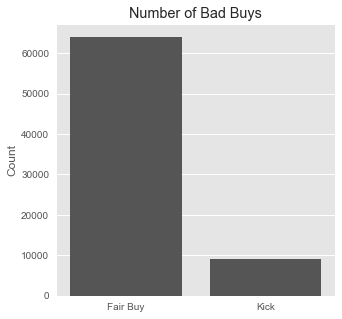

In [4]:
badbuys = list(collections.Counter(data['IsBadBuy'].tolist()).values())
labels = ['Fair Buy','Kick']
badbuys_df = pd.DataFrame(data=badbuys,columns=["y"])
badbuys_df['x'] = labels
badbuys_df
fig,ax = plt.subplots()
fig.set_size_inches(5,5)
sn.barplot(data=badbuys_df,x='x', y='y',ax=ax,color="#555555")
ax.set(xlabel='', ylabel='Count',title="Number of Bad Buys")

In [5]:
np.sum(data['IsBadBuy'])

8976

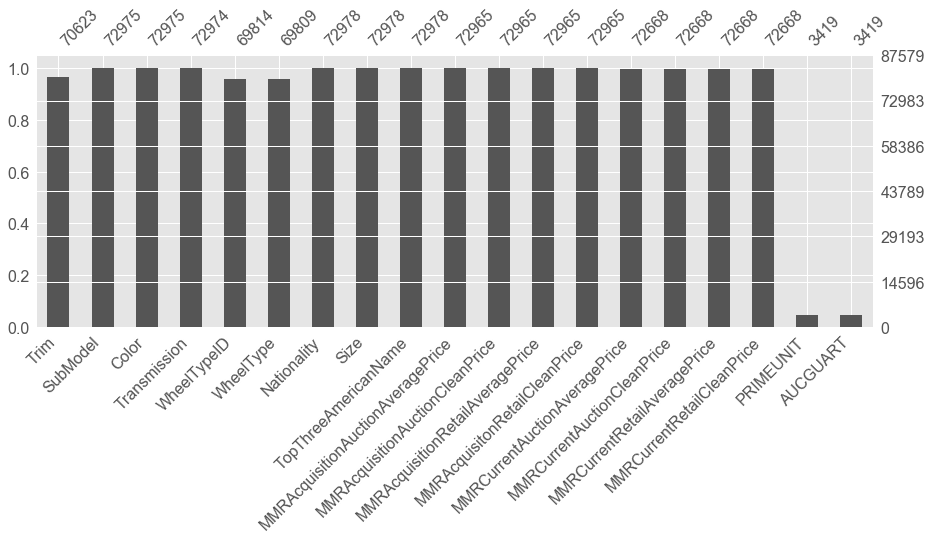

In [11]:
# Missing Value Analysis
missingValueColumns = data.columns[data.isnull().any()].tolist()
msno.bar(data[missingValueColumns],\
            figsize=(15,5),color="#555555",fontsize=16,labels=True,)

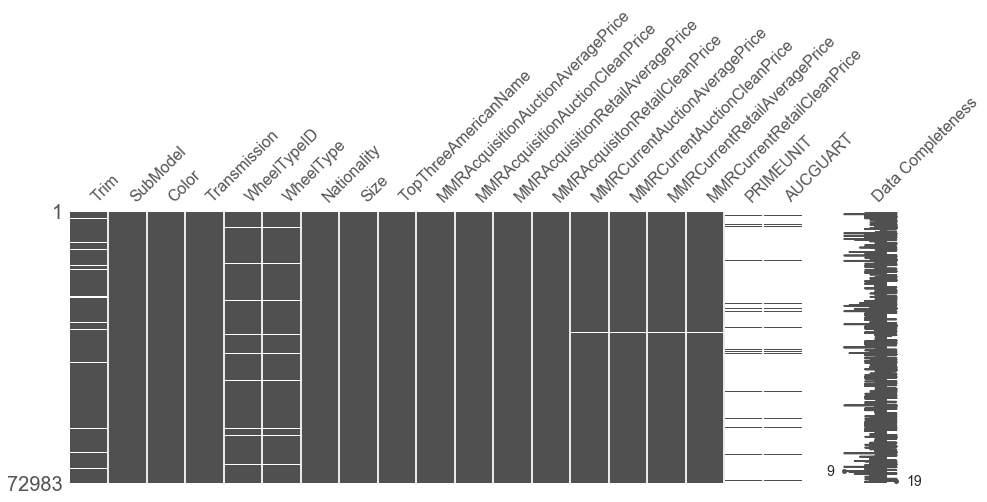

In [12]:
msno.matrix(data[missingValueColumns],width_ratios=(10,1),\
            figsize=(15,5),color=(80/255,80/255,80/255),fontsize=16,sparkline=True,labels=True)

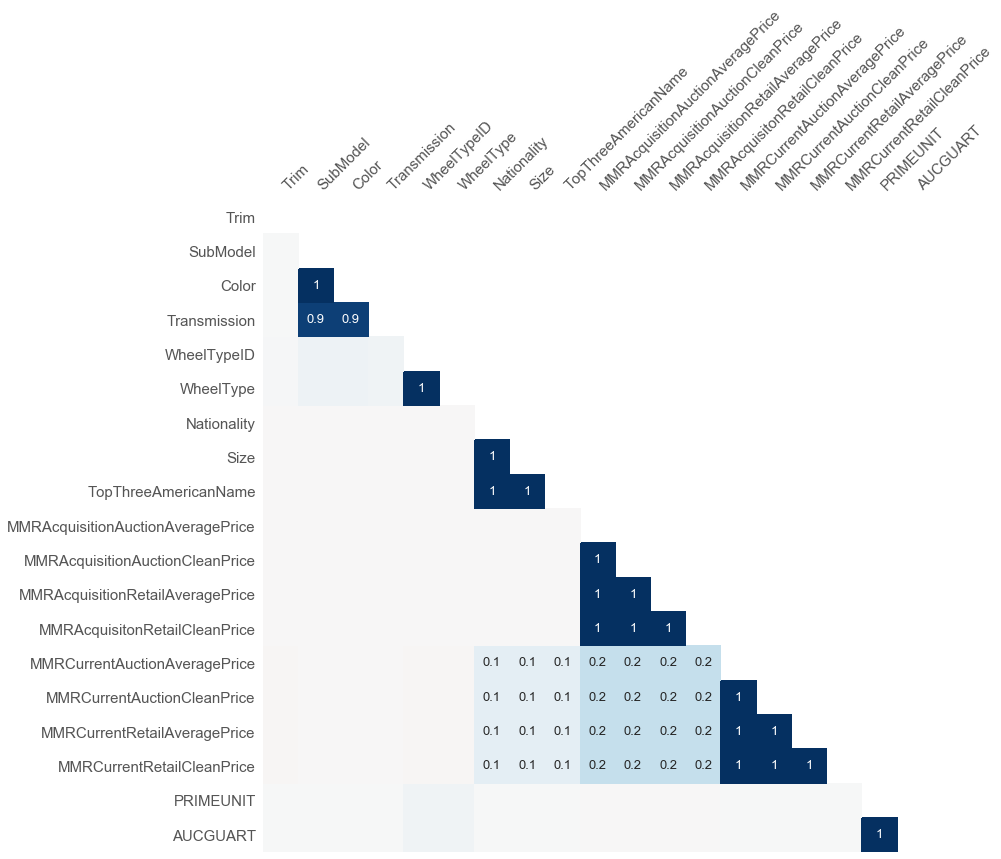

In [15]:
msno.heatmap(data[missingValueColumns],figsize=(12,12),fontsize=15)

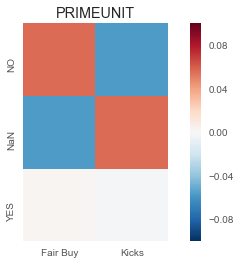

In [13]:
badBuy = pd.get_dummies(data['IsBadBuy'])
badBuy.columns = ['Fair Buy','Kicks']
primeUnit = pd.get_dummies(data['PRIMEUNIT'].fillna('NaN'))
primeUnit = primeUnit.join(badBuy)
# print(primeUnit.head())
corrMatt1 = primeUnit.corr().iloc[:3,3:]
fig,ax= plt.subplots()
fig.set_size_inches(8,4)
sn.heatmap(corrMatt1,vmax=.1, square=True)
ax.set(title="PRIMEUNIT")

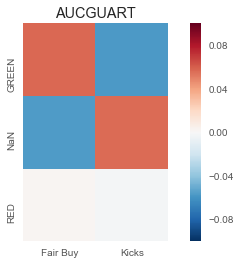

In [14]:
aucguart = pd.get_dummies(data['AUCGUART'].fillna('NaN'))
aucguart = aucguart.join(badBuy)
corrMatt2 = aucguart.corr().iloc[:3,3:]
fig,ax= plt.subplots()
fig.set_size_inches(8,4)
sn.heatmap(corrMatt2, vmax=.1, square=True)
ax.set(title="AUCGUART")

['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
dataFilterd shape: (69501, 17)


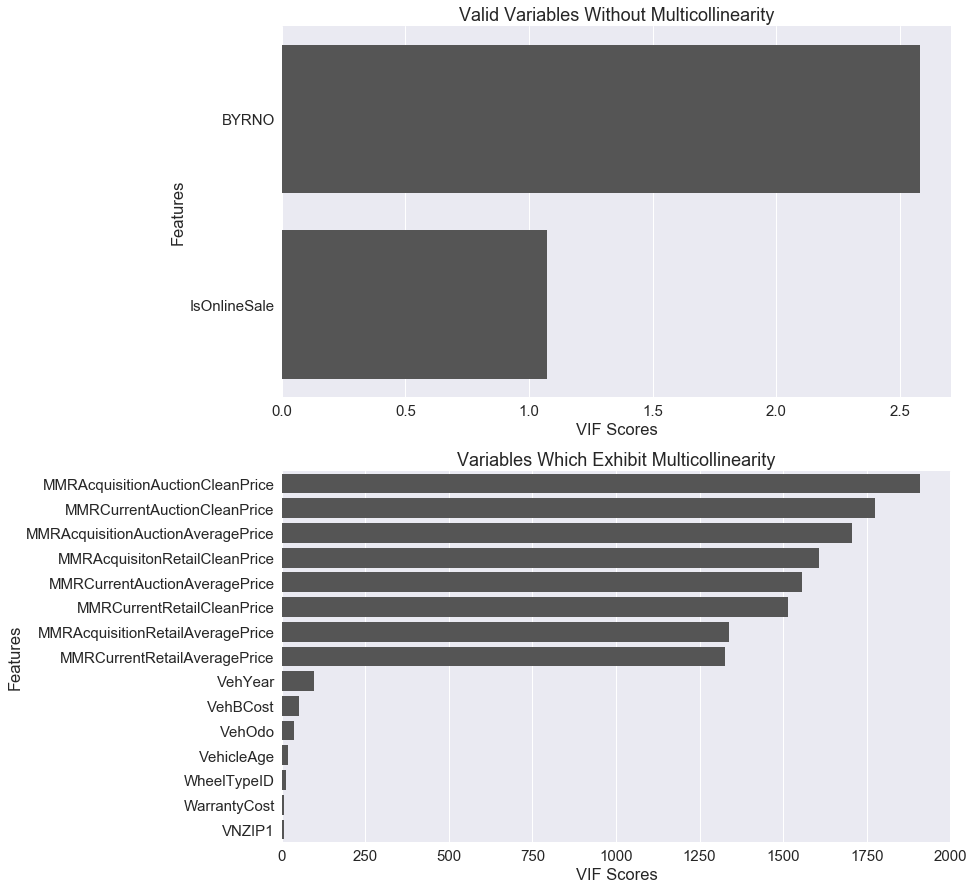

In [24]:
# Multicollinearity Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


numericalCol = list(data._get_numeric_data().columns)
numericalCol = [x for x in numericalCol if not x in ['IsBadBuy','RefId']]
print(numericalCol)
dataFilterd = data[numericalCol].dropna()
print("dataFilterd shape:",dataFilterd.shape)
vifDict = calculate_vif_(dataFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

sn.set(font_scale=1.5)
fig,(ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(12,15)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#555555")
sn.barplot(data=variablesWithMC,x="vifScore",y="variables",ax=ax2,orient="h",color="#555555")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

In [26]:
from fancyimpute import MICE
MCCols = [key for key,value in vifDict.items() if value > 5]
MCData = np.array(data[MCCols])
MCData_filled = MICE().complete(MCData)

[MICE] Completing matrix with shape (72983, 15)
[MICE] Starting imputation round 1/110, elapsed time 0.015
[MICE] Starting imputation round 2/110, elapsed time 0.280
[MICE] Starting imputation round 3/110, elapsed time 0.500
[MICE] Starting imputation round 4/110, elapsed time 0.702
[MICE] Starting imputation round 5/110, elapsed time 0.905
[MICE] Starting imputation round 6/110, elapsed time 1.109
[MICE] Starting imputation round 7/110, elapsed time 1.300
[MICE] Starting imputation round 8/110, elapsed time 1.502
[MICE] Starting imputation round 9/110, elapsed time 1.691
[MICE] Starting imputation round 10/110, elapsed time 1.891
[MICE] Starting imputation round 11/110, elapsed time 2.086
[MICE] Starting imputation round 12/110, elapsed time 2.291
[MICE] Starting imputation round 13/110, elapsed time 2.537
[MICE] Starting imputation round 14/110, elapsed time 2.889
[MICE] Starting imputation round 15/110, elapsed time 3.142
[MICE] Starting imputation round 16/110, elapsed time 3.394
[

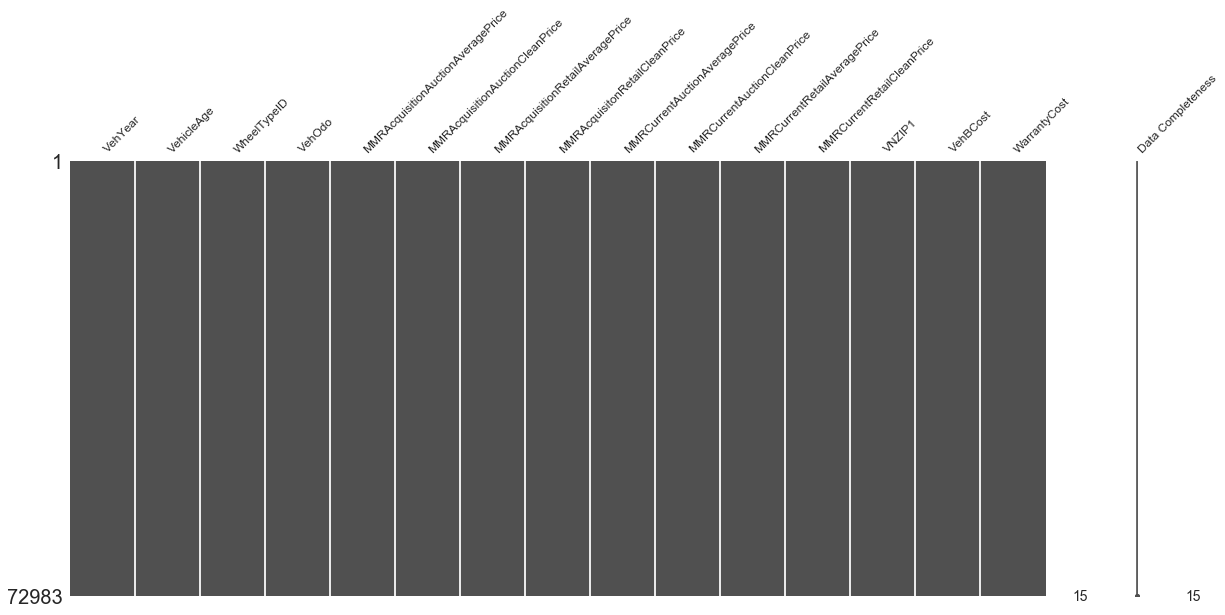

In [28]:
# MCData = pd.DataFrame(MCData,columns=MCCols)
MCData_filled_df = pd.DataFrame(np.ndarray.round(MCData_filled,decimals=-1),columns=MCCols)
# print(MCData_filled.describe())
msno.matrix(MCData_filled_df,width_ratios=(10,1),\
            figsize=(20,8),color=(80/255,80/255,80/255),fontsize=12,sparkline=True,labels=True)

In [18]:
data[MCCols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VehYear,72983.0,2005.343052,1.731252,2001.0,2004.0,2005.0,2007.0,2010.0
VehicleAge,72983.0,4.176644,1.712210,0.0,3.0,4.0,5.0,9.0
WheelTypeID,69814.0,1.494299,0.521290,0.0,1.0,1.0,2.0,3.0
VehOdo,72983.0,71499.995917,14578.913128,4825.0,61837.0,73361.0,82436.0,115717.0
MMRAcquisitionAuctionAveragePrice,72965.0,6128.909217,2461.992768,0.0,4273.0,6097.0,7765.0,35722.0
MMRAcquisitionAuctionCleanPrice,72965.0,7373.636031,2722.491986,0.0,5406.0,7303.0,9021.0,36859.0
MMRAcquisitionRetailAveragePrice,72965.0,8497.034332,3156.285284,0.0,6280.0,8444.0,10651.0,39080.0
MMRAcquisitonRetailCleanPrice,72965.0,9850.928240,3385.789541,0.0,7493.0,9789.0,12088.0,41482.0
MMRCurrentAuctionAveragePrice,72668.0,6132.081287,2434.567723,0.0,4275.0,6062.0,7736.0,35722.0
MMRCurrentAuctionCleanPrice,72668.0,7390.681827,2686.248852,0.0,5414.0,7313.0,9013.0,36859.0


In [19]:
MCData_filled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VehYear,72983.0,2004.956497,4.999845,2000.0,2000.0,2000.0,2010.0,2010.0
VehicleAge,72983.0,2.128441,4.093211,0.0,0.0,0.0,0.0,10.0
WheelTypeID,72983.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VehOdo,72983.0,71500.004659,14578.907356,4820.0,61840.0,73360.0,82440.0,115720.0
MMRAcquisitionAuctionAveragePrice,72983.0,6129.047860,2461.729942,0.0,4270.0,6100.0,7760.0,35720.0
MMRAcquisitionAuctionCleanPrice,72983.0,7373.830070,2722.198624,0.0,5410.0,7300.0,9020.0,36860.0
MMRAcquisitionRetailAveragePrice,72983.0,8497.287588,3155.938263,0.0,6280.0,8450.0,10650.0,39080.0
MMRAcquisitonRetailCleanPrice,72983.0,9851.182467,3385.389375,0.0,7490.0,9790.0,12090.0,41480.0
MMRCurrentAuctionAveragePrice,72983.0,6131.050793,2431.786040,0.0,4280.0,6060.0,7730.0,35720.0
MMRCurrentAuctionCleanPrice,72983.0,7389.278599,2683.015919,0.0,5420.0,7310.0,9010.0,36860.0


In [29]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of categorical feature are imputed with the most frequent value
        in column.

        Columns of numerical feature are imputed with median of column.

        """

    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
                               if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                              index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data_filled = data.drop(['PurchDate','PRIMEUNIT','AUCGUART'],axis=1)
data_filled_cols = data_filled.columns
data_filled[MCCols] = MCData_filled_df
data_filled = DataFrameImputer().fit_transform(data_filled)
data_filled_df = pd.DataFrame(data_filled,columns=data_filled_cols)
data_filled_df.head().transpose()

,0,1,2,3,4
RefId,1,2,3,4,5
IsBadBuy,0,0,0,0,0
Auction,ADESA,ADESA,ADESA,ADESA,ADESA
VehYear,2010,2000,2000,2000,2000
VehicleAge,0,0,0,0,0
Make,MAZDA,DODGE,DODGE,DODGE,FORD
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6,NEON,FOCUS
Trim,i,ST,SXT,SXT,ZX3
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV,4D SEDAN,2D COUPE ZX3
Color,RED,WHITE,MAROON,SILVER,SILVER


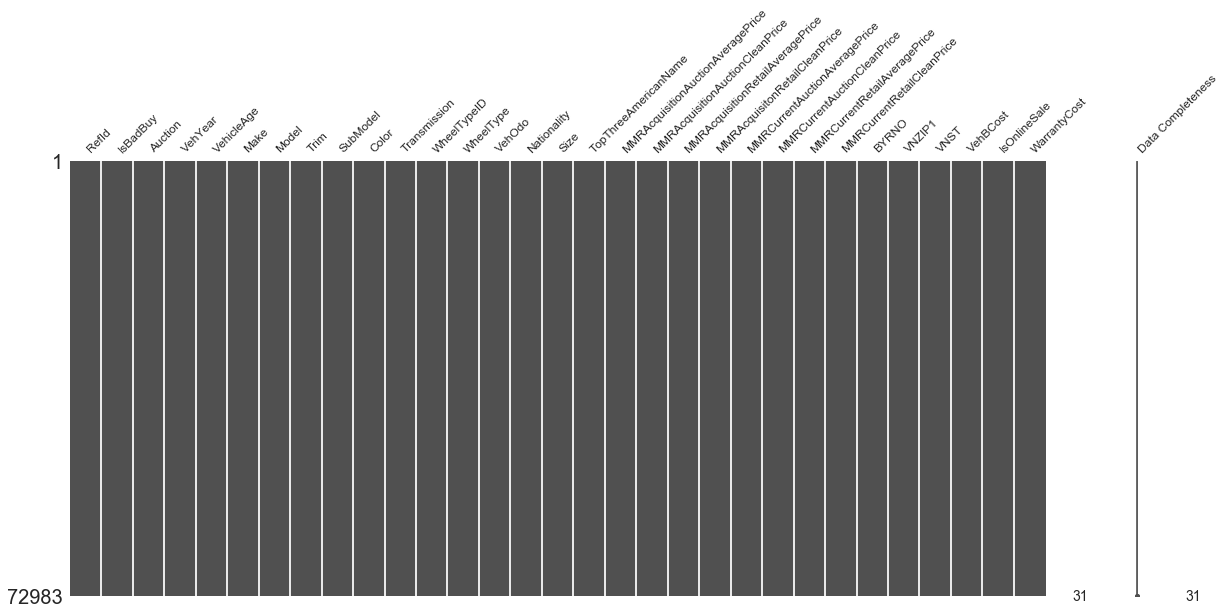

In [30]:
msno.matrix(data_filled_df,width_ratios=(10,1),\
            figsize=(20,8),color=(80/255,80/255,80/255),fontsize=12,sparkline=True,labels=True)

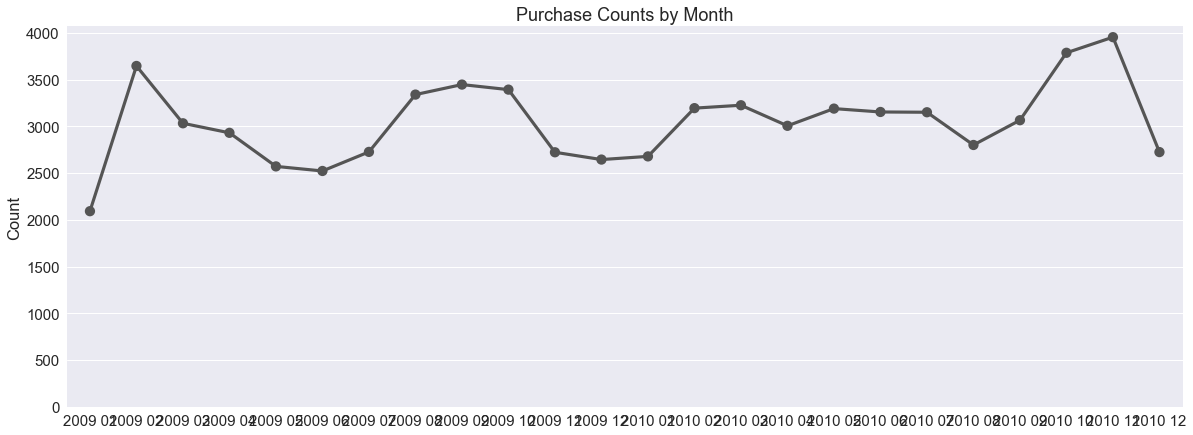

In [32]:
purchDate = data['PurchDate'].tolist()
purchDate = [x.strftime('%Y %m') for x in purchDate]
dateCount = collections.Counter(purchDate)
# dates
purchDate_df = pd.DataFrame(data=list(dateCount.keys()),columns=['x'])
purchDate_df['y'] = list(dateCount.values())
purchDate_df.sort_values(by=['x'],ascending=True,inplace=True)
fig,ax = plt.subplots()
fig.set_size_inches(20,7)
sn.pointplot(data=purchDate_df,x='x',y='y', ax=ax,color="#555555")
ax.set_ylim(bottom=0)
ax.set(xlabel='', ylabel='Count',title="Purchase Counts by Month")

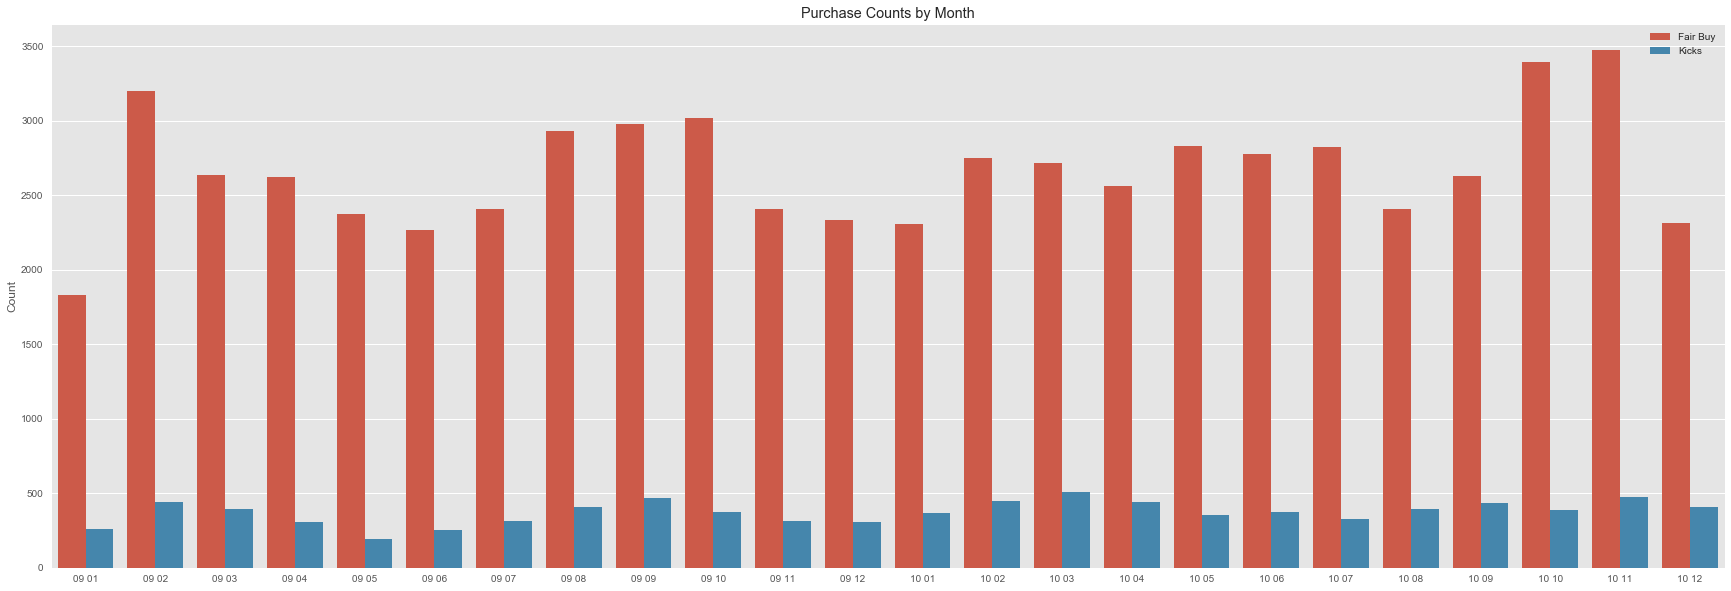

In [86]:
purchDate = data['PurchDate'].tolist()
purchDate = [x.strftime('%y %m') for x in purchDate]
# dates
purchDate_df = pd.DataFrame(data=purchDate,columns=['x'])
purchDate_df['h'] = data['IsBadBuy']
purchDate_df.sort_values(by=['x'],ascending=True,inplace=True)
fig,ax = plt.subplots()
fig.set_size_inches(30,10)
sn.countplot(data=purchDate_df,x='x',hue ='h', ax=ax)
ax.set(xlabel='', ylabel='Count',title="Purchase Counts by Month")
ax.legend(['Fair Buy','Kicks'])

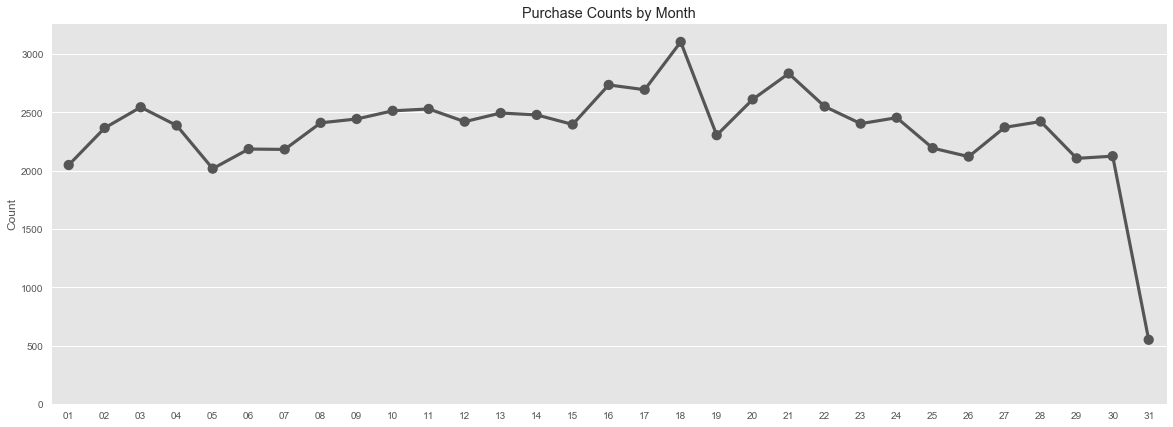

In [25]:
purchDate = data['PurchDate'].tolist()
purchDate = [x.strftime('%d') for x in purchDate]
dateCount = collections.Counter(purchDate)
# dates
purchDate_df = pd.DataFrame(data=list(dateCount.keys()),columns=['x'])
purchDate_df['y'] = list(dateCount.values())
fig,ax = plt.subplots()
fig.set_size_inches(20,7)
sn.pointplot(data=purchDate_df,x='x',y='y', ax=ax,color="#555555")
ax.set_ylim(bottom=0)
ax.set(xlabel='', ylabel='Count',title="Purchase Counts by Month")

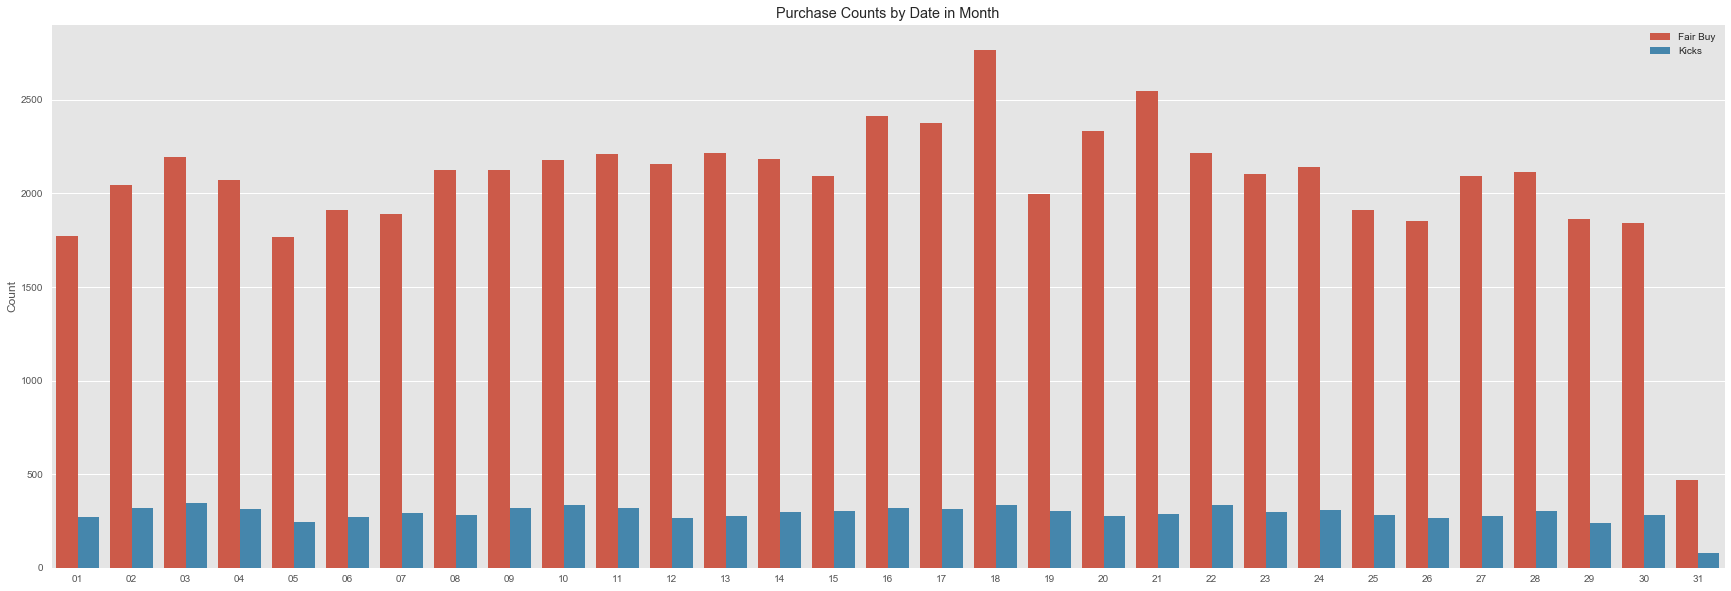

In [26]:
purchDate = data['PurchDate'].tolist()
purchDate = [x.strftime('%d') for x in purchDate]
# dates
purchDate_df = pd.DataFrame(data=purchDate,columns=['x'])
purchDate_df['h'] = data['IsBadBuy']
fig,ax = plt.subplots()
fig.set_size_inches(30,10)
sn.countplot(data=purchDate_df,x='x',hue ='h', ax=ax)
ax.set(xlabel='', ylabel='Count',title="Purchase Counts by Date in Month")
ax.legend(['Fair Buy','Kicks'])

In [27]:
first = data['PurchDate'].describe()['first']
data_filled_df['PurchDate'] = (data['PurchDate'] - first)/pd.Timedelta('1 days 00:00:00')
data_filled_df['PurchDate'].describe()

count    72983.000000
mean       370.119370
std        210.602136
min          0.000000
25%        196.000000
50%        381.000000
75%        555.000000
max        724.000000
Name: PurchDate, dtype: float64

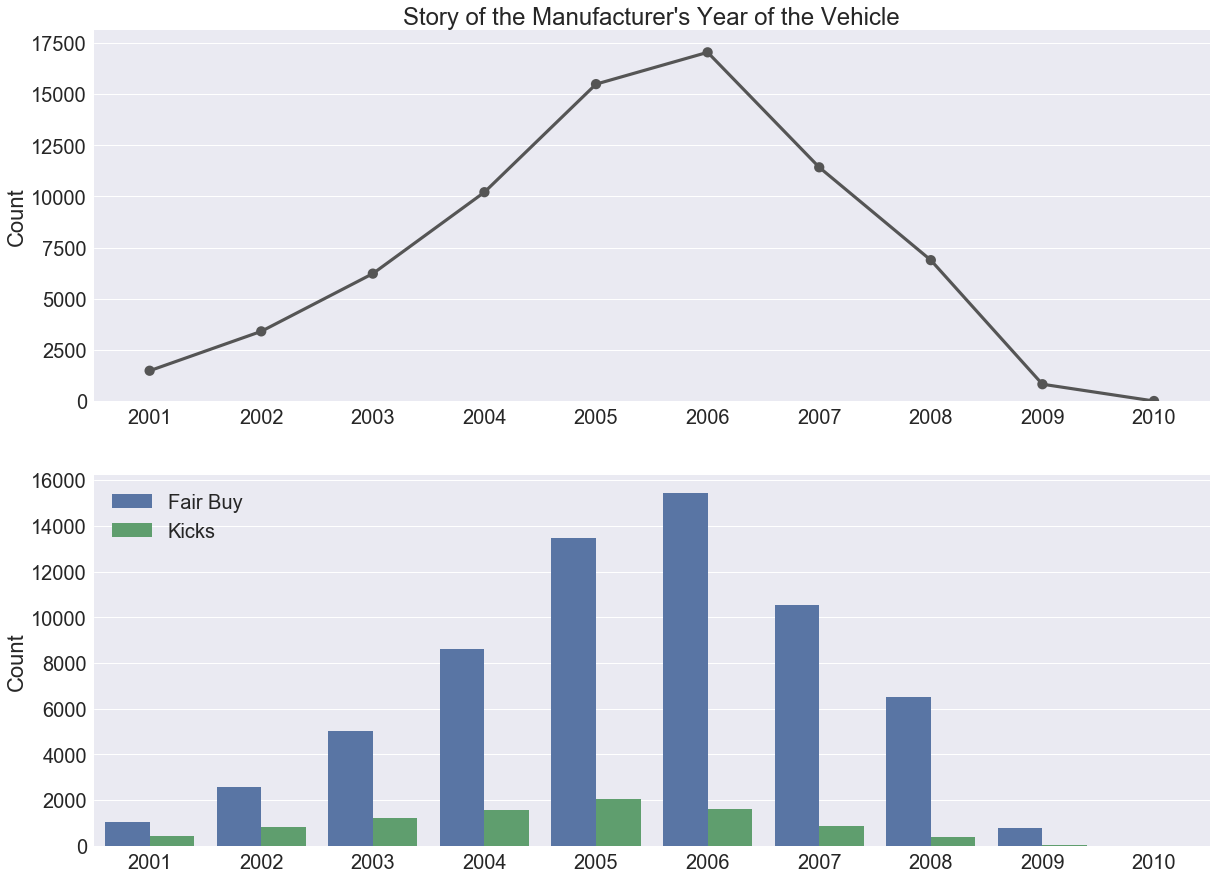

In [33]:
vehYear = data['VehYear'].tolist()
yearCount = collections.Counter(vehYear)
# dates
vehYear_df = pd.DataFrame(data=vehYear,columns=['x'])
yearCount_df = pd.DataFrame(data=list(yearCount.keys()),columns=['x'])
yearCount_df['y'] = list(yearCount.values())
vehYear_df['h'] = data['IsBadBuy']
sn.set(font_scale=2)
fig,(ax1,ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20,15)
sn.pointplot(data=yearCount_df,x='x',y='y', ax=ax1,color="#555555")
sn.countplot(data=vehYear_df,x='x',hue ='h', ax=ax2)
ax1.set_ylim(bottom=0)
ax1.set(xlabel='', ylabel='Count',title="Story of the Manufacturer's Year of the Vehicle")
ax2.set(xlabel='', ylabel='Count',title="")
ax2.legend(['Fair Buy','Kicks'])

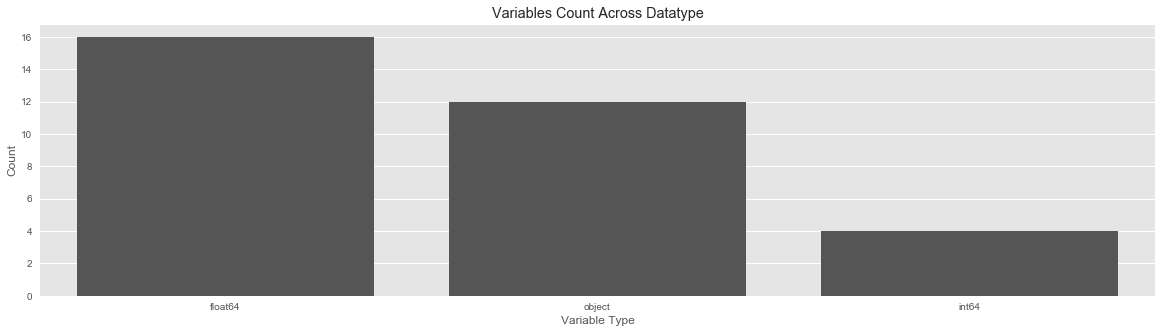

In [30]:
dataTypeDf = pd.DataFrame(data_filled_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax,color="#555555")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [34]:
cate_cols = [f for f in data_filled_df.columns if data_filled_df[f].dtype=='object']
cate_data = data_filled_df[cate_cols]

for f in cate_cols:
    tmp = pd.get_dummies(data_filled_df[f])
    col_names = [f + '.' + x for x in tmp.columns]
    tmp.columns = col_names
    cate_data = cate_data.drop([f],axis=1).join(tmp)

cate_data.head()

# enc = [] # initialize laber encoder list

# for f in cate_cols:
#     enc.append(preprocessing.LabelEncoder())
#     enc[-1].fit(data_filled_df[f])
#     data_filled_df[f] = enc[-1].transform(data_filled_df[f])
    
# ohe = preprocessing.OneHotEncoder(sparse=False)
# ohe.fit(data_filled_df[cate_cols])
# cate_data = ohe.transform(data_filled_df[cate_cols])
# cate_data = pd.DataFrame(cate_data)
# cate_data.columns = [str(x) for x in list(range(len(cate_data.columns)))]
# cate_data.head()

,Auction.ADESA,Auction.MANHEIM,Auction.OTHER,Make.ACURA,Make.BUICK,Make.CADILLAC,Make.CHEVROLET,Make.CHRYSLER,Make.DODGE,Make.FORD,...,VNST.OK,VNST.OR,VNST.PA,VNST.SC,VNST.TN,VNST.TX,VNST.UT,VNST.VA,VNST.WA,VNST.WV
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
data_ohed_df = data_filled_df.drop(cate_cols,axis=1).join(cate_data)
data_ohed_df.head()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,...,VNST.OK,VNST.OR,VNST.PA,VNST.SC,VNST.TN,VNST.TX,VNST.UT,VNST.VA,VNST.WA,VNST.WV
0,1,0,2010.0,0.0,0.0,89050.0,8160.0,9830.0,11640.0,13600.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2000.0,0.0,0.0,93590.0,6850.0,8380.0,10900.0,12570.0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,2000.0,0.0,0.0,73810.0,3200.0,4760.0,6940.0,8460.0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,2000.0,0.0,0.0,65620.0,1890.0,2680.0,4660.0,5690.0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,2000.0,0.0,0.0,69370.0,3910.0,5050.0,7720.0,8710.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data_ohed_df.shape

(72983, 2194)

mean of importance: 13.359625668449198


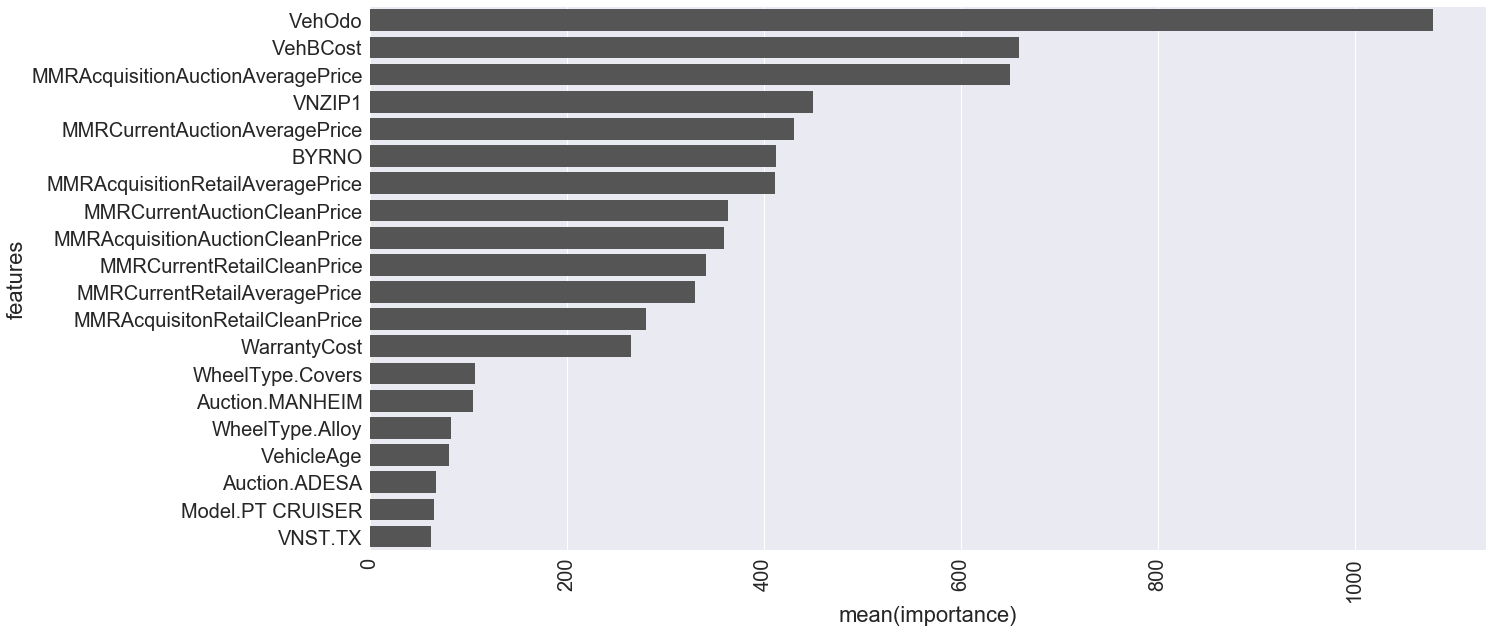

In [37]:
# Top Features Selection
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings

# for f in data_filled_df.columns:
#     if data_filled_df[f].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(data_filled_df[f].values)) 
#         data_filled_df[f] = lbl.transform(list(data_filled_df[f].values))

train_y = data_ohed_df['IsBadBuy']
train_X = data_ohed_df.drop(["RefId", "IsBadBuy"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(20),x="importance",y="features",ax=ax,orient="h",color="#555555")
importance_mean = np.mean(features['importance'])
print("mean of importance:",importance_mean)

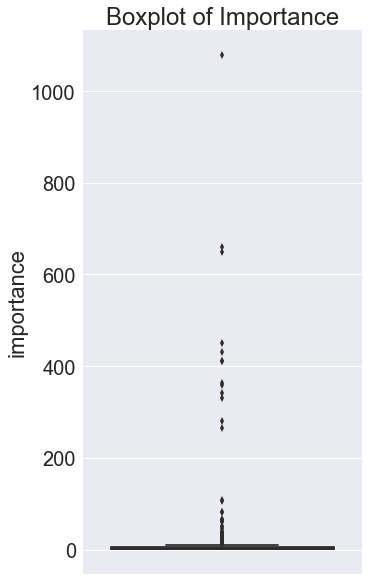

In [38]:
features['label'] = [0] * features.shape[0]
fig,ax= plt.subplots()
fig.set_size_inches(5,10)
plt.setp( ax.get_xticklabels(), visible=False)
sn.boxplot(x="label", y="importance", data=features,ax=ax,color="#34495e")
ax.set(ylabel='importance',xlabel="",title="Boxplot of Importance")

In [39]:
topFeatures = features['features'][:50]
topFeatures

2                                 VehOdo
73                              VehBCost
68     MMRAcquisitionAuctionAveragePrice
72                                VNZIP1
1          MMRCurrentAuctionAveragePrice
10                                 BYRNO
8       MMRAcquisitionRetailAveragePrice
117          MMRCurrentAuctionCleanPrice
80       MMRAcquisitionAuctionCleanPrice
7             MMRCurrentRetailCleanPrice
81          MMRCurrentRetailAveragePrice
69         MMRAcquisitonRetailCleanPrice
15                          WarrantyCost
95                      WheelType.Covers
11                       Auction.MANHEIM
3                        WheelType.Alloy
67                            VehicleAge
53                         Auction.ADESA
35                      Model.PT CRUISER
24                               VNST.TX
0                                VehYear
12                              Trim.Bas
22                          Color.SILVER
63                           Color.WHITE
34              

In [40]:
num_cols = [x for x in topFeatures if not x in list(cate_data.columns)]
num_data = data_ohed_df[num_cols]
scaler = preprocessing.StandardScaler().fit(num_data)
num_data = scaler.transform(num_data)
num_data = pd.DataFrame(num_data[:],columns=num_cols)
cate_cols_reduced = [x for x in topFeatures if x in list(cate_data.columns)]
cate_data_reduced = data_ohed_df[cate_cols_reduced]
data_reduced_df = num_data.join(cate_data_reduced)
data_reduced_df.head()

,VehOdo,VehBCost,MMRAcquisitionAuctionAveragePrice,VNZIP1,MMRCurrentAuctionAveragePrice,BYRNO,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRAcquisitionAuctionCleanPrice,MMRCurrentRetailCleanPrice,...,Model.AVEO,Color.GOLD,Color.GREEN,TopThreeAmericanName.FORD,Color.BEIGE,Color.MAROON,Make.DODGE,VNST.AZ,Model.MAXIMA,VNST.PA
0,1.203802,0.208769,0.825012,-0.933872,0.542378,-0.170036,0.995816,0.432625,0.902282,0.685634,...,0,0,0,0,0,0,0,0,0,0
1,1.515213,0.491608,0.292863,-0.933872,0.546490,-0.260831,0.761336,0.682346,0.369620,0.800566,...,0,0,0,0,0,0,1,0,0,0
2,0.158449,-1.035724,-1.189842,-0.933872,-0.859881,-0.260831,-0.493449,-0.681799,-0.960196,-0.436464,...,0,0,0,0,0,1,1,0,0,0
3,-0.403325,-1.488267,-1.721991,-0.933872,-1.764564,-0.260831,-1.215902,-1.766405,-1.724290,-1.398262,...,0,0,0,0,0,0,1,0,0,0
4,-0.146103,-1.544835,-0.901425,-0.933872,-1.184745,-0.260831,-0.246295,-1.121605,-0.853664,-0.675401,...,0,0,0,1,0,0,0,0,0,0


In [55]:
import math
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

In [41]:
# Train Test Split

X = data_reduced_df
print("X shape:", X.shape)
Y = pd.get_dummies(data['IsBadBuy'])
print("Y shape:", Y.shape)

randIndex = np.random.permutation(X.shape[0])

X_train = np.array(X.iloc[randIndex[:-10000],:])
X_train = X_train.reshape(X_train.shape).T
print('X_train shape:',X_train.shape)

Y_train = np.array(Y.iloc[randIndex[:-10000],:])
Y_train = Y_train.reshape(Y_train.shape).T
print('Y_train shape:',Y_train.shape)

X_test =np.array(X.iloc[randIndex[-10000:],:])
X_test = X_test.reshape(X_test.shape).T
print('X_test shape:',X_test.shape)

Y_test = np.array(Y.iloc[randIndex[-10000:],:])
Y_test = Y_test.reshape(Y_test.shape).T
print('Y_test shape:',Y_test.shape)

X shape: (72983, 50)
Y shape: (72983, 2)
X_train shape: (50, 62983)
Y_train shape: (2, 62983)
X_test shape: (50, 10000)
Y_test shape: (2, 10000)


In [44]:
# For models other than NN
# Train Test Split
X = data_reduced_df
print("X shape:", X.shape)
# Y = pd.get_dummies(data['IsBadBuy'])
Y = data['IsBadBuy']
print("Y shape:", Y.shape)

randIndex = np.random.permutation(X.shape[0])

X_train = np.array(X.iloc[randIndex[:-10000],:])
# X_train = X_train.reshape(X_train.shape).T
print('X_train shape:',X_train.shape)

Y_train = np.array(Y.iloc[randIndex[:-10000],])
# Y_train = Y_train.reshape(Y_train.shape).T
print('Y_train shape:',Y_train.shape)

X_test =np.array(X.iloc[randIndex[-10000:],:])
# X_test = X_test.reshape(X_test.shape).T
print('X_test shape:',X_test.shape)

Y_test = np.array(Y.iloc[randIndex[-10000:],])
# Y_test = Y_test.reshape(Y_test.shape).T
print('Y_test shape:',Y_test.shape)

X shape: (72983, 50)
Y shape: (72983,)
X_train shape: (62983, 50)
Y_train shape: (62983,)
X_test shape: (10000, 50)
Y_test shape: (10000,)


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
#     KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.1, probability=True),
    NuSVC(probability=True),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
#     GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis()
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, Y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_train)
    acc0 = accuracy_score(Y_train, train_predictions)
    print("Train Accuracy: {:.4%}".format(acc0))
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(Y_test, test_predictions)
    print("Test Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(Y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    precision_recall(Y_train, train_predictions, Y_test, test_predictions)
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

In [65]:
def precision_recall(Y_train, train_predictions, Y_test, test_predictions):
    print('****For Training Set****')
    Y_train_diff = Y_train - train_predictions
    Y_train_sum = Y_train + train_predictions

    Y_train_counter1 = collections.Counter(Y_train_diff)
    Y_train_counter2 = collections.Counter(Y_train_sum)
    Y_train_counter = {2: Y_train_counter2[2], -1: Y_train_counter1[-1], 1: Y_train_counter1[1], 0: Y_train_counter2[0]}
    print('True Positive: ',Y_train_counter[2])
    print('False Positive: ',Y_train_counter[-1])
    print('False Negative: ',Y_train_counter[1])
    print('True Negative: ',Y_train_counter[0])

    print('****For Test Set****')
    Y_test_diff = Y_test - test_predictions
    Y_test_sum = Y_test + test_predictions

    Y_test_counter1 = collections.Counter(Y_test_diff)
    Y_test_counter2 = collections.Counter(Y_test_sum)
    Y_test_counter = {2: Y_test_counter2[2], -1: Y_test_counter1[-1], 1: Y_test_counter1[1], 0: Y_test_counter2[0]}
    print('True Positive: ',Y_test_counter[2])
    print('False Positive: ',Y_test_counter[-1])
    print('False Negative: ',Y_test_counter[1])
    print('True Negative: ',Y_test_counter[0])

In [76]:
def random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,\
                  max_features = 5, max_depth=None, min_samples_split=2,\
                                 random_state=0, bootstrap = True):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_features = max_features, max_depth=max_depth, min_samples_split=min_samples_split,\
                                 random_state=random_state, bootstrap = bootstrap)
    clf.fit(X_train, Y_train)
    print('****Results****')
    train_predictions = clf.predict(X_train)
    acc0 = accuracy_score(Y_train, train_predictions)
    print("Train Accuracy: {:.4%}".format(acc0))
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(Y_test, test_predictions)
    print("Test Accuracy: {:.4%}".format(acc))
    
    precision_recall(Y_train, train_predictions, Y_test, test_predictions)
    return train_predictions, test_predictions
    

In [77]:
train_p,test_p = random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = 50,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1000%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  60
False Positive:  49
False Negative:  1141
True Negative:  8750


In [71]:
random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = 9,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1000%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  37
False Positive:  26
False Negative:  1164
True Negative:  8773


In [57]:
clf = RandomForestClassifier(n_estimators=100, max_features = 7, max_depth=None, min_samples_split=2,\
                             random_state=0, bootstrap = True)
clf.fit(X_train, Y_train)
print('****Results****')
train_predictions = clf.predict(X_train)
acc0 = accuracy_score(Y_train, train_predictions)
print("Train Accuracy: {:.4%}".format(acc0))
test_predictions = clf.predict(X_test)
acc = accuracy_score(Y_test, test_predictions)
print("Test Accuracy: {:.4%}".format(acc))
    
# train_predictions = clf.predict_proba(X_train)
# ll = log_loss(Y_test, train_predictions)
# print("Log Loss: {}".format(ll))

print('****For Training Set****')
Y_train_diff = Y_train - train_predictions
Y_train_sum = Y_train + train_predictions

Y_train_counter1 = collections.Counter(Y_train_diff)
Y_train_counter2 = collections.Counter(Y_train_sum)
Y_train_counter = {2: Y_train_counter2[2], -1: Y_train_counter1[-1], 1: Y_train_counter1[1], 0: Y_train_counter2[0]}
print('True Positive: ',Y_train_counter[2])
print('False Positive: ',Y_train_counter[-1])
print('False Negative: ',Y_train_counter[1])
print('True Negative: ',Y_train_counter[0])

print('****For Test Set****')
Y_test_diff = Y_test - test_predictions
Y_test_sum = Y_test + test_predictions

Y_test_counter1 = collections.Counter(Y_test_diff)
Y_test_counter2 = collections.Counter(Y_test_sum)
Y_test_counter = {2: Y_test_counter2[2], -1: Y_test_counter1[-1], 1: Y_test_counter1[1], 0: Y_test_counter2[0]}
print('True Positive: ',Y_test_counter[2])
print('False Positive: ',Y_test_counter[-1])
print('False Negative: ',Y_test_counter[1])
print('True Negative: ',Y_test_counter[0])

****Results****
Train Accuracy: 99.9952%
Test Accuracy: 88.0300%
****For Training Set****
True Positive:  7772
False Positive:  0
False Negative:  3
True Negative:  55208
****For Test Set****
True Positive:  34
False Positive:  30
False Negative:  1167
True Negative:  8769


In [58]:
clf = RandomForestClassifier(n_estimators=1000, max_features = 7, max_depth=None, min_samples_split=2,\
                             random_state=0, bootstrap = True)
clf.fit(X_train, Y_train)
print('****Results****')
train_predictions = clf.predict(X_train)
acc0 = accuracy_score(Y_train, train_predictions)
print("Train Accuracy: {:.4%}".format(acc0))
test_predictions = clf.predict(X_test)
acc = accuracy_score(Y_test, test_predictions)
print("Test Accuracy: {:.4%}".format(acc))
    
# train_predictions = clf.predict_proba(X_train)
# ll = log_loss(Y_test, train_predictions)
# print("Log Loss: {}".format(ll))

print('****For Training Set****')
Y_train_diff = Y_train - train_predictions
Y_train_sum = Y_train + train_predictions

Y_train_counter1 = collections.Counter(Y_train_diff)
Y_train_counter2 = collections.Counter(Y_train_sum)
Y_train_counter = {2: Y_train_counter2[2], -1: Y_train_counter1[-1], 1: Y_train_counter1[1], 0: Y_train_counter2[0]}
print('True Positive: ',Y_train_counter[2])
print('False Positive: ',Y_train_counter[-1])
print('False Negative: ',Y_train_counter[1])
print('True Negative: ',Y_train_counter[0])

print('****For Test Set****')
Y_test_diff = Y_test - test_predictions
Y_test_sum = Y_test + test_predictions

Y_test_counter1 = collections.Counter(Y_test_diff)
Y_test_counter2 = collections.Counter(Y_test_sum)
Y_test_counter = {2: Y_test_counter2[2], -1: Y_test_counter1[-1], 1: Y_test_counter1[1], 0: Y_test_counter2[0]}
print('True Positive: ',Y_test_counter[2])
print('False Positive: ',Y_test_counter[-1])
print('False Negative: ',Y_test_counter[1])
print('True Negative: ',Y_test_counter[0])

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.0900%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  33
False Positive:  23
False Negative:  1168
True Negative:  8776


In [68]:
random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = 5,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.0800%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  22
False Positive:  13
False Negative:  1179
True Negative:  8786


In [69]:
random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1500,max_features = 5,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.0600%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  21
False Positive:  14
False Negative:  1180
True Negative:  8785


In [72]:
for i in range(15,50,5):
    random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = i,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1400%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  49
False Positive:  34
False Negative:  1152
True Negative:  8765
****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1500%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  52
False Positive:  36
False Negative:  1149
True Negative:  8763


KeyboardInterrupt: 

In [74]:
random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = 25,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1200%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  56
False Positive:  43
False Negative:  1145
True Negative:  8756


In [75]:
random_forest(X_train,Y_train,X_test,Y_test,n_estimators=1000,max_features = 30,\
              max_depth=None, min_samples_split=2,random_state=0, bootstrap = True)

****Results****
Train Accuracy: 100.0000%
Test Accuracy: 88.1900%
****For Training Set****
True Positive:  7775
False Positive:  0
False Negative:  0
True Negative:  55208
****For Test Set****
True Positive:  57
False Positive:  37
False Negative:  1144
True Negative:  8762


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X_train)
pca_df = pd.DataFrame()
pca_df['x'] = X_r[0]
pca_df['y'] = X_r[1]
pca_df['h'] = Y_train
sns.lmplot("x", "y", data=pca_df, hue='h', fit_reg=False)

In [57]:
# create placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of number of training examples: 58386
    n_y -- scalar, number of classes: 1
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=(n_x,None))
    Y = tf.placeholder(tf.float32,shape=(n_y,None))
    
    return X, Y

In [58]:
# Initializing the parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
#     tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [100,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [100,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [50,100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [50,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [50,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [50,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable("W4", [30,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [30,1], initializer = tf.zeros_initializer())
    W5 = tf.get_variable("W5", [2,30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b5 = tf.get_variable("b5", [2,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5}
    
    return parameters

In [59]:
# Forward propagation in tensorflow

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last SOFTMAX unit
    """
    
#     keep_prob = tf.Variable(0.5,tf.float32)
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1,X),b1)                                         
    A1 = tf.nn.relu(Z1)
#     drop_A1 = tf.nn.dropout(A1, keep_prob)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              
    A2 = tf.nn.relu(Z2) 
#     drop_A2 = tf.nn.dropout(A2, keep_prob)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4,A3),b4)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5,A4),b5)
    
    return Z5

In [70]:
def compute_cost(Z5, Y, parameters, lambd):
    """
    Computes the cost
    
    """
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    
    logits = tf.transpose(Z5)
    labels = tf.transpose(Y)
    
#     lambd = 0.0005
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)) \
            + lambd * tf.nn.l2_loss(W1) + lambd * tf.nn.l2_loss(W2) + lambd * tf.nn.l2_loss(W3) + \
        lambd * tf.nn.l2_loss(W4) + lambd * tf.nn.l2_loss(W5)
    
    return cost

In [61]:
# random mini batches

def random_mini_batches(X, Y, mini_batch_size = 4096, seed = None):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    if not seed is None:
        np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [62]:
# Forward propagation for predict

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z5 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                         
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                              
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4,A3),b4)
    A4 = tf.nn.relu(Z4)
    Z5 = tf.add(tf.matmul(W5,A4),b5)
    
    return Z5

In [63]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    W5 = tf.convert_to_tensor(parameters["W5"])
    b5 = tf.convert_to_tensor(parameters["b5"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4,
              "W5": W5,
              "b5": b5}
    
    x = tf.placeholder("float", [50, 1])
    
    z5 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z5)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [71]:
# Building the model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, learning_rate_decay = None,
          num_epochs = 3000, minibatch_size = 512, print_cost = True, l2_lambda = None):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y, parameters, l2_lambda)
    
    # learning rate decay
    if not learning_rate_decay is None:
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate, global_step, 100000, learning_rate_decay, staircase=True)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.713288
Cost after epoch 100: 0.350515
Cost after epoch 200: 0.335533
Cost after epoch 300: 0.326193
Cost after epoch 400: 0.318522
Cost after epoch 500: 0.312210
Cost after epoch 600: 0.309183
Cost after epoch 700: 0.309445
Cost after epoch 800: 0.305593
Cost after epoch 900: 0.300984
Cost after epoch 1000: 0.299661
Cost after epoch 1100: 0.299510
Cost after epoch 1200: 0.304116
Cost after epoch 1300: 0.297350
Cost after epoch 1400: 0.294952
Cost after epoch 1500: 0.293651
Cost after epoch 1600: 0.293968
Cost after epoch 1700: 0.294992
Cost after epoch 1800: 0.292394
Cost after epoch 1900: 0.289911


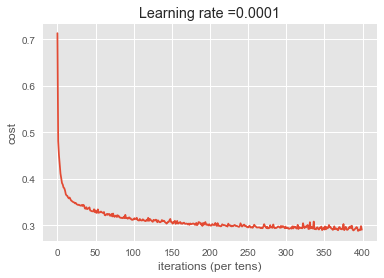

Parameters have been trained!
Train Accuracy: 0.909722
Test Accuracy: 0.8478


In [73]:
parameters5 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 2000, l2_lambda = 0.0015)

Cost after epoch 0: 0.659188
Cost after epoch 100: 0.348953
Cost after epoch 200: 0.329748
Cost after epoch 300: 0.317228
Cost after epoch 400: 0.305980
Cost after epoch 500: 0.299155
Cost after epoch 600: 0.295103
Cost after epoch 700: 0.297012
Cost after epoch 800: 0.287528
Cost after epoch 900: 0.283253
Cost after epoch 1000: 0.284425
Cost after epoch 1100: 0.279468
Cost after epoch 1200: 0.279175
Cost after epoch 1300: 0.273849
Cost after epoch 1400: 0.280472
Cost after epoch 1500: 0.269973
Cost after epoch 1600: 0.271105
Cost after epoch 1700: 0.268965
Cost after epoch 1800: 0.266452
Cost after epoch 1900: 0.263003


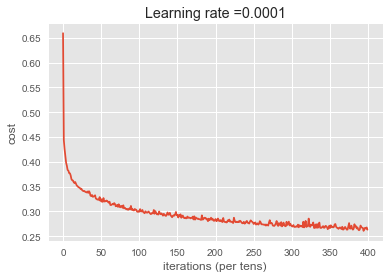

Parameters have been trained!
Train Accuracy: 0.926202
Test Accuracy: 0.8468


In [72]:
parameters4 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 2000, l2_lambda = 0.001)

Cost after epoch 0: 0.604822
Cost after epoch 100: 0.341878
Cost after epoch 200: 0.321235
Cost after epoch 300: 0.306790
Cost after epoch 400: 0.291997
Cost after epoch 500: 0.282731
Cost after epoch 600: 0.275410
Cost after epoch 700: 0.273083
Cost after epoch 800: 0.262178
Cost after epoch 900: 0.255702
Cost after epoch 1000: 0.256219
Cost after epoch 1100: 0.249248
Cost after epoch 1200: 0.249588
Cost after epoch 1300: 0.241363
Cost after epoch 1400: 0.243965
Cost after epoch 1500: 0.235376
Cost after epoch 1600: 0.235214
Cost after epoch 1700: 0.239566
Cost after epoch 1800: 0.230250
Cost after epoch 1900: 0.230597


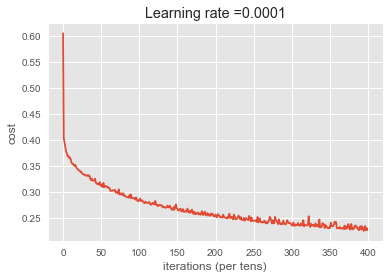

Parameters have been trained!
Train Accuracy: 0.934427
Test Accuracy: 0.8251


In [69]:
parameters3 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 2000)

Cost after epoch 0: 0.582969
Cost after epoch 100: 0.334470
Cost after epoch 200: 0.312302
Cost after epoch 300: 0.295349
Cost after epoch 400: 0.279872
Cost after epoch 500: 0.269367
Cost after epoch 600: 0.261554
Cost after epoch 700: 0.257707
Cost after epoch 800: 0.244726
Cost after epoch 900: 0.239141
Cost after epoch 1000: 0.237508
Cost after epoch 1100: 0.227446
Cost after epoch 1200: 0.226424
Cost after epoch 1300: 0.219465
Cost after epoch 1400: 0.219773
Cost after epoch 1500: 0.215200
Cost after epoch 1600: 0.217736
Cost after epoch 1700: 0.204880
Cost after epoch 1800: 0.202662
Cost after epoch 1900: 0.201519


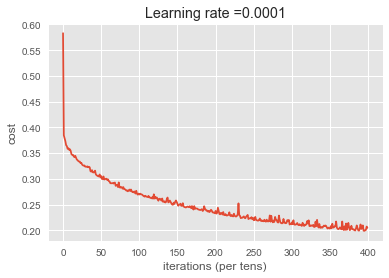

Parameters have been trained!
Train Accuracy: 0.953527
Test Accuracy: 0.817


In [65]:
parameters1 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 2000)

Cost after epoch 0: 0.561048
Cost after epoch 100: 0.321557
Cost after epoch 200: 0.297300
Cost after epoch 300: 0.278572
Cost after epoch 400: 0.261445
Cost after epoch 500: 0.247501
Cost after epoch 600: 0.237130
Cost after epoch 700: 0.227397
Cost after epoch 800: 0.215572
Cost after epoch 900: 0.209301


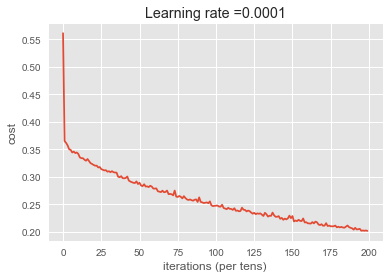

Parameters have been trained!
Train Accuracy: 0.936618
Test Accuracy: 0.8248


In [67]:
parameters2 = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 1000)

Cost after epoch 0: 0.768916
Cost after epoch 100: 0.368118
Cost after epoch 200: 0.356243
Cost after epoch 300: 0.342255
Cost after epoch 400: 0.332185
Cost after epoch 500: 0.321323
Cost after epoch 600: 0.313658
Cost after epoch 700: 0.307428
Cost after epoch 800: 0.298881
Cost after epoch 900: 0.292864
Cost after epoch 1000: 0.287347
Cost after epoch 1100: 0.281733
Cost after epoch 1200: 0.278064
Cost after epoch 1300: 0.272791
Cost after epoch 1400: 0.268263
Cost after epoch 1500: 0.262844
Cost after epoch 1600: 0.260334
Cost after epoch 1700: 0.255635
Cost after epoch 1800: 0.252765
Cost after epoch 1900: 0.250041
Cost after epoch 2000: 0.246530
Cost after epoch 2100: 0.243214
Cost after epoch 2200: 0.241819
Cost after epoch 2300: 0.237649
Cost after epoch 2400: 0.235456
Cost after epoch 2500: 0.232805
Cost after epoch 2600: 0.232647
Cost after epoch 2700: 0.228117
Cost after epoch 2800: 0.226009
Cost after epoch 2900: 0.222956


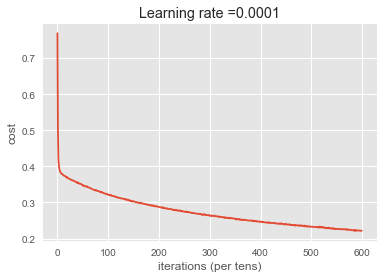

Parameters have been trained!
Train Accuracy: 0.933919
Test Accuracy: 0.8342


In [122]:
parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs = 3000)

Cost after epoch 0: 0.549401
Cost after epoch 100: 0.320138
Cost after epoch 200: 0.290047
Cost after epoch 300: 0.268822
Cost after epoch 400: 0.252677
Cost after epoch 500: 0.241489
Cost after epoch 600: 0.228600
Cost after epoch 700: 0.216739
Cost after epoch 800: 0.207782
Cost after epoch 900: 0.199304


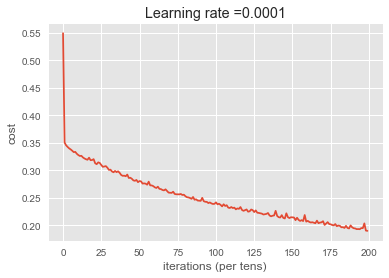

Parameters have been trained!
Train Accuracy: 0.926742
Test Accuracy: 0.8469


In [112]:
learning_rate = 0.0001
learning_rate_decay = None
num_epochs = 1000
minibatch_size = 512
print_cost = True

ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
tf.set_random_seed(1)                             # to keep consistent results
seed = 3                                          # to keep consistent results
(n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[0]                            # n_y : output size
costs = []                                        # To keep track of the cost

# Create Placeholders of shape (n_x, n_y)
X, Y = create_placeholders(n_x, n_y)

# Initialize parameters
parameters = initialize_parameters()

# Forward propagation: Build the forward propagation in the tensorflow graph
Z3 = forward_propagation(X, parameters)

# Cost function: Add cost function to tensorflow graph
cost = compute_cost(Z3, Y, parameters)

# learning rate decay
if not learning_rate_decay is None:
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, 100000, learning_rate_decay, staircase=True)

# Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# Initialize all the variables
init = tf.global_variables_initializer()

# Start the session to compute the tensorflow graph
with tf.Session() as sess:
    
    # Run the initialization
    sess.run(init)
    
    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.                       # Defines a cost related to an epoch
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
            
            epoch_cost += minibatch_cost / num_minibatches

        # Print the cost every epoch
        if print_cost == True and epoch % 100 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # lets save the parameters in a variable
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

In [77]:
def predict_all(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    W5 = tf.convert_to_tensor(parameters["W5"])
    b5 = tf.convert_to_tensor(parameters["b5"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4,
              "W5": W5,
              "b5": b5}
    
    x = tf.placeholder("float", [X.shape[0], X.shape[1]])
    
    z5 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z5)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [78]:
# calculate precision and recall

def precision_recall(X_train, Y_train_1col, X_test, Y_test_1col, parameters):
    
    Y_train_predict = predict_all(X_train, parameters)
    Y_test_predict = predict_all(X_test, parameters)
    
    Y_train_diff = Y_train_1col - Y_train_predict
    Y_train_sum = Y_train_1col + Y_train_predict
    Y_test_diff = Y_test_1col - Y_test_predict
    Y_test_sum = Y_test_1col + Y_test_predict
    
    Y_train_counter1 = collections.Counter(Y_train_diff)
    Y_train_counter2 = collections.Counter(Y_train_sum)
    Y_train_counter = {2: Y_train_counter2[2], -1: Y_train_counter1[-1], 1: Y_train_counter1[1], 0: Y_train_counter2[0]}
    print("train result:",Y_train_counter)
    train_precision = Y_train_counter[2]/(Y_train_counter[2] + Y_train_counter[-1])
    train_recall = Y_train_counter[2]/(Y_train_counter[2] + Y_train_counter[1])
    train_f = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    Y_test_counter1 = collections.Counter(Y_test_diff)
    Y_test_counter2 = collections.Counter(Y_test_sum)
    Y_test_counter = {2: Y_test_counter2[2], -1: Y_test_counter1[-1], 1: Y_test_counter1[1], 0: Y_test_counter2[0]}
    print("test result:",Y_test_counter)
    test_precision = Y_test_counter[2]/(Y_test_counter[2] + Y_test_counter[-1])
    test_recall = Y_test_counter[2]/(Y_test_counter[2] + Y_test_counter[1])
    test_f = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    return train_precision, train_recall, train_f, test_precision, test_recall, test_f

In [82]:
print(precision_recall(X_train, Y_train[1], X_test, Y_test[1], parameters4))

train result: {2: 4157, -1: 1081, 1: 3567, 0: 54178}
test result: {2: 273, -1: 553, 1: 979, 0: 8195}
(0.7936235204276442, 0.5381926462972553, 0.6414133621354728, 0.3305084745762712, 0.21805111821086262, 0.2627526467757459)


In [81]:
Y_train[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)